<a href="https://colab.research.google.com/github/Machine-Learning-Robot-Competition/data_generation/blob/main/Letter_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

(only run once!)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setup Dependencies

(only run once!)

In [1]:
!pip install tensorflow==2.13.1
!pip install keras==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 36.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
     

## Setup Directories

Ensure that these folders exist!

In [ ]:
letter_dir = "/content/drive/MyDrive/ENPH353/letters"
model_dir = "/content/drive/MyDrive/ENPH353/models"

## Prepare for Pipeline

Definitions and declarations

In [1]:
import numpy as np
import re
import concurrent.futures
import cv2
import string
import random
import os

encoding = {
    "A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, "J": 9,
    "K": 10, "L": 11, "M": 12, "N": 13, "O": 14, "P": 15, "Q": 16, "R": 17, "S": 18,
    "T": 19, "U": 20, "V": 21, "W": 22, "X": 23, "Y": 24, "Z": 25, "0": 26, "1": 27,
    "2": 28, "3": 29, "4": 30, "5": 31, "6": 32, "7": 33, "8": 34, "9": 35
}


reversed_encoding = {value: key for key, value in encoding.items()}


def identifier(letter: str):
  return encoding[letter]


def generate_random_string(length=7):
  characters = string.ascii_lowercase + string.digits  # Letters + digits
  return ''.join(random.choice(characters) for _ in range(length))


def get_letter_dir(letter: str):
  return os.path.join(letter_dir, str(identifier(letter)))


def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)]
  return Y

## Extract

Extract all data (using over-engineered concurrent IO) from Google Drive

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
import cv2

# Function to load images in a subdirectory
def load_images_from_subdir(subdir_path):
    images = []
    for filename in os.listdir(subdir_path):
        if filename.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):
            image_path = os.path.join(subdir_path, filename)
            try:
                image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_RGB2GRAY)

                images.append(image)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")
    return images

# Function to process the directory and load images in parallel
def load_images_in_parallel(directory):
    subdirectories = [os.path.join(directory, subdir) for subdir in os.listdir(directory)
                      if os.path.isdir(os.path.join(directory, subdir))]

    images_dict = defaultdict(list)

    # Using ThreadPoolExecutor to parallelize image loading
    with ThreadPoolExecutor() as executor:
        # Map each subdirectory to the load_images_from_subdir function
        results = executor.map(load_images_from_subdir, subdirectories)

        # Populate the dictionary with the results
        for subdir, images in zip(subdirectories, results):
            subdir_name = os.path.basename(subdir)
            images_dict[subdir_name] = images

    return images_dict

images_dict = load_images_in_parallel(letter_dir)

# Print the dictionary to verify
for subdir, images in images_dict.items():
    print(f"Directory '{subdir}' contains {len(images)} images.")

KeyboardInterrupt: 

In [4]:
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

font_filepath = "/content/drive/MyDrive/ENPH353/UbuntuMono-R.ttf"

# Characters to generate
characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# Font size
font_size = 68

# Image size
image_width, image_height = 42, 48

letters = []
img_width = 35
img_height = 40
font_colour = (255, 0, 0)
text_position = (4, -12)
reduced_size = (int(image_width // 1), int(image_height // 1))

# Generate images for each character
for char in characters:
    img = Image.new("RGB", (image_width, image_height), color="white")
    draw = ImageDraw.Draw(img)

    _font_size = font_size if char != 'Q' else 60
    font = ImageFont.truetype(font_filepath, size=_font_size)

    # Calculate text position to center it
    _text_position = text_position if char != 'Q' else (6, -10)
    draw.text(_text_position, char, font_colour, font=font)

    small_img = img.resize(reduced_size, Image.NEAREST)  # Downscale to a low resolution
    pixelated_img = small_img.resize(img.size, Image.NEAREST)  # Upscale back to original size

    np_img = cv2.bitwise_not(cv2.cvtColor(np.array(pixelated_img), cv2.COLOR_RGB2GRAY))
    _, np_img = cv2.threshold(np_img, 10, 255, cv2.THRESH_BINARY)

    # noise = np.abs(np.random.normal(0, 10, np_img.shape).astype(np.uint8))  # Adjust variance for noise
    # noisy_img = cv2.add(np_img, noise)

    # Save the image
    letters.append(np_img)

def distort_letter(img):
  low_frequency_std = 80
  high_frequency_std = 10

  high_frequency_magnitude = 5.0
  low_frequency_magnitude = 5.0
  normalization = np.sqrt(low_frequency_magnitude**2 + high_frequency_magnitude**2)
  amplitude = 0.66

  high_frequency_amplitude = amplitude * high_frequency_magnitude / normalization
  low_frequency_amplitude = amplitude * low_frequency_magnitude / normalization

  noise = np.random.normal(0, 90, (image_height, image_width)).astype(int)

  salted_image = np.clip(img + noise, a_min=0, a_max=255).astype(np.uint8)
  blurred_salted_image = cv2.GaussianBlur(salted_image, (5, 5), 0)
  _, thresholded_blurred_salted_image = cv2.threshold(blurred_salted_image, 128, 255, cv2.THRESH_BINARY)

  return thresholded_blurred_salted_image


import random
import string


encoding = {
    "A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, "J": 9,
    "K": 10, "L": 11, "M": 12, "N": 13, "O": 14, "P": 15, "Q": 16, "R": 17, "S": 18,
    "T": 19, "U": 20, "V": 21, "W": 22, "X": 23, "Y": 24, "Z": 25, "0": 26, "1": 27,
    "2": 28, "3": 29, "4": 30, "5": 31, "6": 32, "7": 33, "8": 34, "9": 35
}

letters_to_generate = {
    "A": 250, "B": 450, "C": 250, "D": 500, "E": 250, "F": 250, "G": 300, "H": 250, "I": 250, "J": 250,
    "K": 250, "L": 250, "M": 250, "N": 250, "O": 550, "P": 250, "Q": 550, "R": 350, "S": 250,
    "T": 250, "U": 400, "V": 250, "W": 250, "X": 250, "Y": 250, "Z": 250, "0": 250, "1": 200, "2": 200,
    "3": 200, "4": 200, "5": 350, "6": 350, "7": 200, "8": 400, "9": 300
}

def identifier(letter: str):
  return encoding[letter]

def get_raw_letter(letter: str):
  return letters[identifier(letter)]

def generate_letter(letter: str):
  return distort_letter(get_raw_letter(letter))

def generate_random_string(length=7):
  characters = string.ascii_lowercase + string.digits  # Letters + digits
  return ''.join(random.choice(characters) for _ in range(length))

generated_letters = {}

def generate_and_save_letter(letter: str):
  letter_id = str(identifier(letter))
  generated_letter = generate_letter(letter)
  if letter_id not in generated_letters.keys():
    generated_letters[letter_id] = []
  generated_letters[letter_id].append(generated_letter)

for letter, num_to_generate in letters_to_generate.items():
  for _ in range(num_to_generate):
    generate_and_save_letter(letter)

# Dataset Preparation

In [5]:
import math
import random


Y_dataset_raw = []
X_dataset_raw = []

# Organize every letter into the format (letter, letter_image) so that we can
# shuffle the list without messing up the labels
pair_list = []
for label, images in generated_letters.items():
  for image in images:
    pair_list.append((int(label), image))
random.shuffle(pair_list)

# Populate the datasets with shuffled data
for pair in pair_list:
  label, image = pair

  Y_dataset_raw.append(label)
  X_dataset_raw.append(image)


X_dataset = np.array(X_dataset_raw)
Y_dataset = convert_to_one_hot(np.array(Y_dataset_raw), len(encoding.values()))

# Now, perform a train/validation set split
VALIDATION_SPLIT = 0.2

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

X_train_dataset = np.expand_dims(X_train_dataset, axis=-1)
X_val_dataset = np.expand_dims(X_val_dataset, axis=-1)

x_width, y_width, channels = X_train_dataset[0].shape

# Training

Create the network and train it

In [6]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=20,       # Random rotation of images
    width_shift_range=0.2,   # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,         # Random shear
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest',     # Fill missing pixels after transformations
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)
datagen.fit(X_train_dataset)  # Fit parameters (e.g., mean/std) based on training data
train_generator = datagen.flow(X_train_dataset, Y_train_dataset, batch_size=64)


In [8]:
from tensorflow.keras import models, layers, losses, optimizers, callbacks, regularizers

convolution_model = models.Sequential()

convolution_model.add(layers.Conv2D(128, (5, 5), activation='relu', input_shape=(x_width, y_width, 1), kernel_regularizer=regularizers.l2(0.01)))
convolution_model.add(layers.MaxPooling2D((2, 2)))
convolution_model.add(layers.BatchNormalization())

convolution_model.add(layers.Conv2D(256, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
convolution_model.add(layers.MaxPooling2D((2, 2)))
convolution_model.add(layers.BatchNormalization())

convolution_model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
convolution_model.add(layers.BatchNormalization())

convolution_model.add(layers.GlobalAveragePooling2D())
# convolution_model.add(layers.Dense(1024, activation='relu'))
# convolution_model.add(layers.Dropout(0.50))
convolution_model.add(layers.Dense(512, activation='relu'))
convolution_model.add(layers.Dropout(0.50))
convolution_model.add(layers.Dense(1024, activation='relu'))
convolution_model.add(layers.Dropout(0.50))
convolution_model.add(layers.Dense(512, activation='relu'))
convolution_model.add(layers.Dropout(0.50))
convolution_model.add(layers.Dense(len(encoding.keys()), activation='softmax'))

convolution_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 38, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 19, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 22, 19, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 15, 256)       819456    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 7, 256)         0         
 g2D)                                                            
                                                        

In [9]:
LEARNING_RATE = 1.00e-4
convolution_model.compile(loss=losses.CategoricalCrossentropy(),
                          optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                          metrics=['acc'])

In [10]:
reset_weights(convolution_model)

callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_conv = convolution_model.fit(train_generator,
                                    validation_data=(X_val_dataset, Y_val_dataset),
                                    callbacks=[callback],
                                    epochs=50,
                                    batch_size=64)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


132/132 [==============================] - 29s 207ms/step - loss: 7.0738 - acc: 0.1100 - val_loss: 5.9055 - val_acc: 0.2029
Epoch 2/50
132/132 [==============================] - 27s 202ms/step - loss: 5.5413 - acc: 0.2287 - val_loss: 4.2747 - val_acc: 0.5262
Epoch 3/50
132/132 [==============================] - 27s 201ms/step - loss: 4.4561 - acc: 0.3599 - val_loss: 3.3686 - val_acc: 0.5767
Epoch 4/50
132/132 [==============================] - 27s 201ms/step - loss: 3.6543 - acc: 0.4912 - val_loss: 2.8365 - val_acc: 0.6567
Epoch 5/50
132/132 [==============================] - 27s 202ms/step - loss: 3.0671 - acc: 0.5830 - val_loss: 2.1850 - val_acc: 0.8024
Epoch 6/50
132/132 [==============================] - 27s 204ms/step - loss: 2.6133 - acc: 0.6623 - val_loss: 1.8204 - val_acc: 0.9105
Epoch 7/50
132/132 [==============================] - 27s 203ms/step - loss: 2.2425 - acc: 0.7290 - val_loss: 1.8569 - val_acc: 0.8538
Epoch 8/50
132/132 [==============================] - 27s 205ms/st

# Inspect results

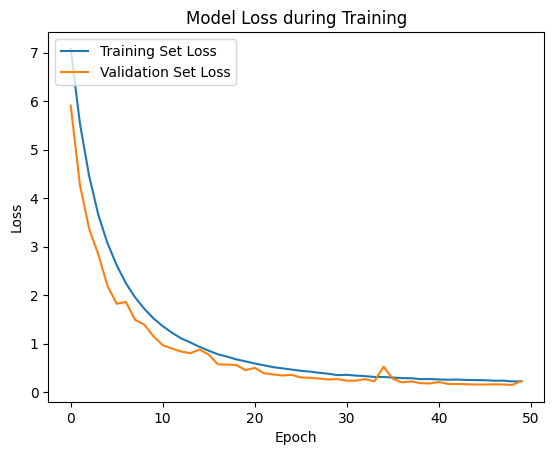

In [16]:
import matplotlib.pyplot as plt

plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Model Loss during Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set Loss', 'Validation Set Loss'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 138ms/step
Network says: 0


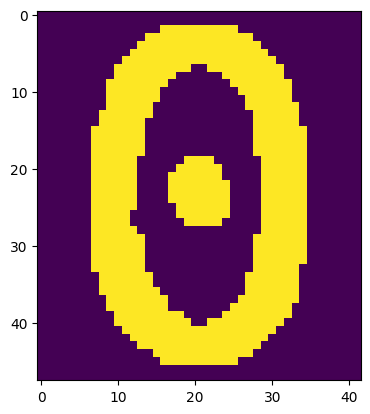

In [12]:
i = 112

def predict(X_data, model):
  input_data = np.expand_dims(X_data, axis=0)
  result = model.predict(input_data)
  return reversed_encoding[np.argmax(result[0])]

example = X_val_dataset[i]
print(f"Network says: {predict(example, convolution_model)}")
plt.imshow(example)

In [13]:
y_pred_test = [predict(plate, convolution_model) for plate in X_val_dataset]
y_true = [reversed_encoding[np.argmax(y)] for y in Y_val_dataset]

1/1 [==============================] - 0s 21ms/step


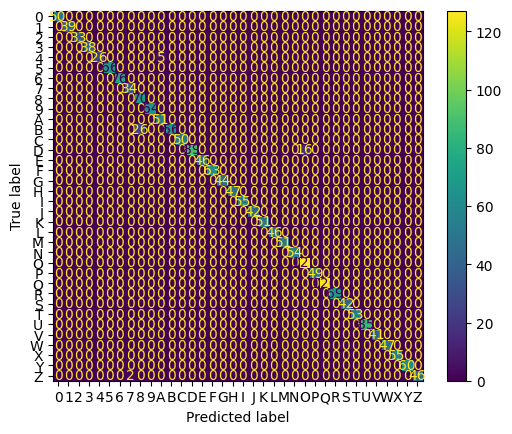

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred_test)
plt.show()

# Save the model
with a random name

In [15]:
convolution_model.save(f'{model_dir}/{generate_random_string()}.keras')

NameError: name 'model_dir' is not defined